# Activity Classification on RA Features using Transformers

In [20]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader

In [21]:
data = pd.read_csv('data/DSA_features.csv')
data.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1


In [22]:
le_activity = LabelEncoder()
data['activity'] = le_activity.fit_transform(data['activity'])

le_people = LabelEncoder()
data['people'] = le_people.fit_transform(data['people'])

data.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,12,0
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,12,0
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,12,0
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,12,0
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,12,0


In [4]:
X = data.filter(regex='RA_').values
y = data['activity'].values

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

(5107, 54) (1277, 54) (2736, 54)


In [6]:
class DSASequenceDataset(Dataset):
    def __init__(self, X, y, sequence_length=5):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length + 1

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.sequence_length], self.y[idx+self.sequence_length-1])

In [7]:
class DSADataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
train_dataset = DSASequenceDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = DSASequenceDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = DSASequenceDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
# train_dataset = DSADataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_dataset = DSADataset(X_val_tensor, y_val_tensor)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test_dataset = DSADataset(X_test_tensor, y_test_tensor)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, input_dim, sequence_length, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout) 
        pe = torch.zeros(sequence_length, input_dim)
        position = torch.arange(0, sequence_length, dtype =                                           
                                                 torch.float).unsqueeze(1) 
        div_term = torch.exp(torch.arange(0, input_dim, 2).float() * (- 
                                             math.log(10000.0) / input_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self,x):
         x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
         return self.dropout(x) 

In [11]:
class DSATransformerClassifier(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_classes, do_pe=False):
        super(DSATransformerClassifier, self).__init__()
        self.do_pe = do_pe
        self.pe = PositionalEncoding(input_dim, sequence_length=5, dropout=0.)
        self.embedding = nn.Linear(input_dim, embed_dim)

        # Transformer Encoder
        self.mha = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.dropout = nn.Dropout(0.25)
        self.ln = nn.LayerNorm(embed_dim)

        # Feed-forward
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        if self.do_pe:
            x = self.pe(x)
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x, _ = self.mha(x, x, x)
        x = self.ln(x)
        x = x.permute(1, 0, 2)
        x = x.mean(dim=1)
        out = self.fc(x)
        return out

### Plain Transformer Training

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = X_train.shape[1]
hidden_size = 256
num_classes = len(np.unique(y))
net = DSATransformerClassifier(
    input_dim=input_dim, 
    embed_dim=hidden_size, 
    num_heads=4, 
    num_classes=num_classes,
    do_pe=False
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

In [13]:
num_epochs = 100
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/100], Train Accuracy: 0.3126, Validation Accuracy: 0.2262
Epoch [20/100], Train Accuracy: 0.3923, Validation Accuracy: 0.2121
Epoch [30/100], Train Accuracy: 0.4480, Validation Accuracy: 0.2113
Epoch [40/100], Train Accuracy: 0.4789, Validation Accuracy: 0.2168
Epoch [50/100], Train Accuracy: 0.5205, Validation Accuracy: 0.2152
Epoch [60/100], Train Accuracy: 0.5379, Validation Accuracy: 0.1995
Epoch [70/100], Train Accuracy: 0.5612, Validation Accuracy: 0.2066
Epoch [80/100], Train Accuracy: 0.5863, Validation Accuracy: 0.1917
Epoch [90/100], Train Accuracy: 0.5853, Validation Accuracy: 0.2050
Epoch [100/100], Train Accuracy: 0.5955, Validation Accuracy: 0.1909


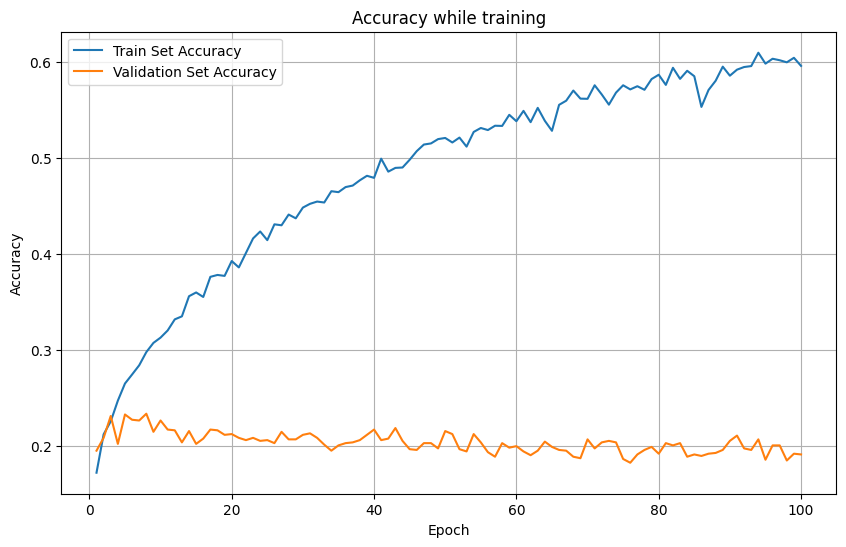

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [15]:
net.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.2156


### Training Transformer with Positional Encoding

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = X_train.shape[1]
hidden_size = 256
num_classes = len(np.unique(y))
net = DSATransformerClassifier(
    input_dim=input_dim, 
    embed_dim=hidden_size, 
    num_heads=4, 
    num_classes=num_classes,
    do_pe=True
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

In [17]:
num_epochs = 100
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/100], Train Accuracy: 0.9091, Validation Accuracy: 0.8790
Epoch [20/100], Train Accuracy: 0.9389, Validation Accuracy: 0.9042
Epoch [30/100], Train Accuracy: 0.9242, Validation Accuracy: 0.8947
Epoch [40/100], Train Accuracy: 0.9569, Validation Accuracy: 0.9049
Epoch [50/100], Train Accuracy: 0.9677, Validation Accuracy: 0.9097
Epoch [60/100], Train Accuracy: 0.9451, Validation Accuracy: 0.8869
Epoch [70/100], Train Accuracy: 0.9504, Validation Accuracy: 0.8672
Epoch [80/100], Train Accuracy: 0.9726, Validation Accuracy: 0.9183
Epoch [90/100], Train Accuracy: 0.9585, Validation Accuracy: 0.9183
Epoch [100/100], Train Accuracy: 0.9681, Validation Accuracy: 0.9073


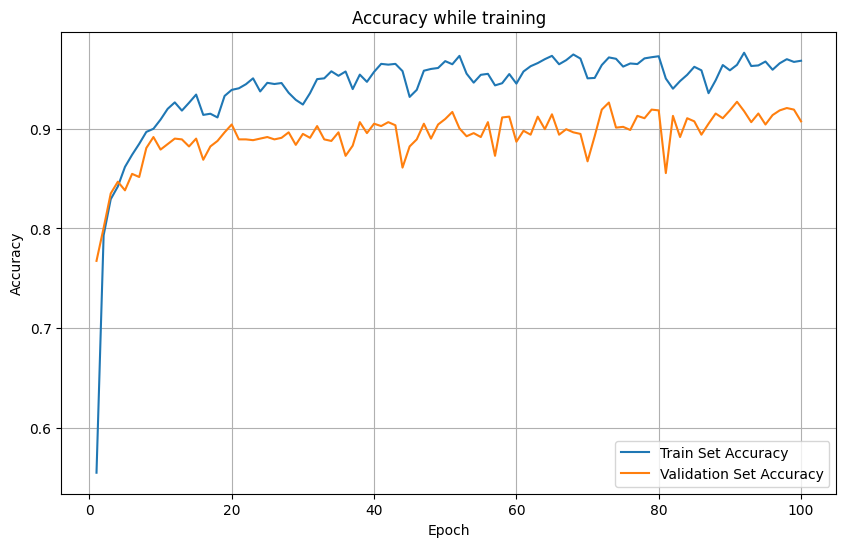

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [19]:
net.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9100
